# MALA MCMC

In [1]:
from utils import *
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import pints.plot
from pints.functionaltests.mala_mcmc import *

# Two dimensional Gaussian

In [2]:
test = run_replicates(np.geomspace(1000, 5000, 8), 10,
                      test_mala_mcmc_on_two_dim_gaussian)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
df.to_csv("experimental_data/mala_mcmc_hamiltonian_2d_gaussian.csv")

/home/fergus/GitRepos/pints-team/method-merge-tests/venv/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


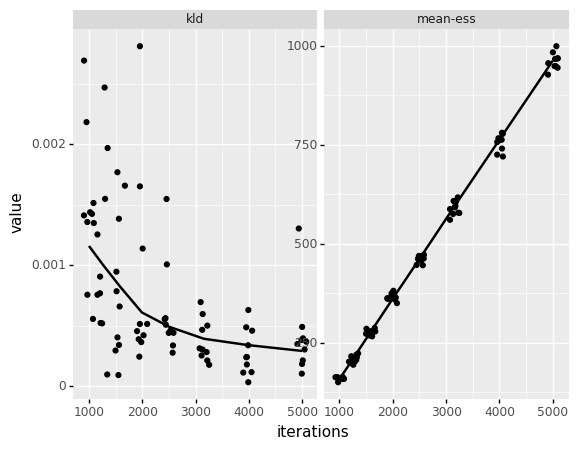

<ggplot: (8753650764749)>

In [3]:
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

The ESS and KLD both trend in the correct directions.

Show example run results.

Using Metropolis-Adjusted Langevin Algorithm (MALA)
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0.5       0.5       0.5       0.5        0:00.0
2     12     0.667     0.667     0.667     0.667      0:00.0
3     16     0.75      0.5       0.75      0.75       0:00.0
20    84     0.81      0.857     0.762     0.905      0:00.0
40    164    0.829     0.732     0.804878  0.927      0:00.1
60    244    0.852459  0.803     0.852459  0.918      0:00.1
80    324    0.889     0.802     0.877     0.889      0:00.1
100   404    0.891     0.812     0.842     0.901      0:00.1
120   484    0.892562  0.835     0.843     0.901      0:00.2
140   564    0.887     0.837     0.858156  0.893617   0:00.2
160   644    0.894     0.826087  0.857     0.894      0:00.2
180   724    0.895     0.834     0.862     0.906      0:00.2
200   804    0.9       0.846     0.851     0.

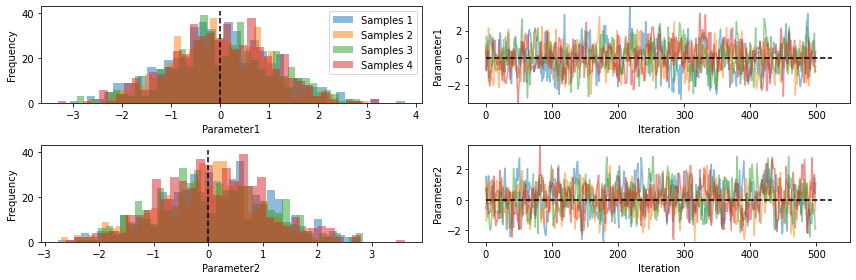

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  0.01    1.05    -2.07   -0.67  -0.01  0.72   2.07     1.01    357.94  275.65
param 2  0.08    1.00    -1.92   -0.59  0.08   0.72   2.04     1.00    375.41  289.10


In [4]:
n_chains = 4
n_iterations = 1000
n_warmup = 500
log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])

# Get initial parameters
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))
x0 = log_prior.sample(n=n_chains)
controller = pints.MCMCController(
            log_pdf, n_chains, x0, method=pints.MALAMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(True)

for sampler in controller.samplers():
    sampler.set_epsilon([1.0, 1.0])

chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.trace(chains, ref_parameters=[0, 0])

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

The parameters are close to their true means.

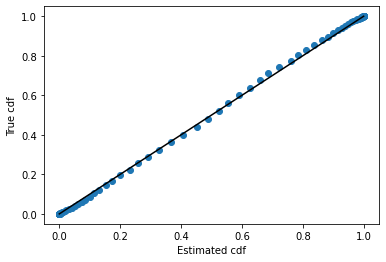

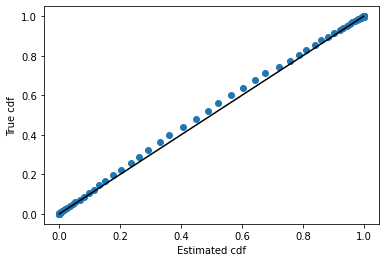

[None, None]

In [5]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], 1) for i in range(2)]

# Correlated Gaussian

In [6]:
test = run_replicates(np.geomspace(1000, 5000, 8), 10,
                      test_mala_mcmc_on_correlated_gaussian)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
df.to_csv("experimental_data/mala_mcmc_correlated_gaussian.csv")

/home/fergus/GitRepos/pints-team/method-merge-tests/venv/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


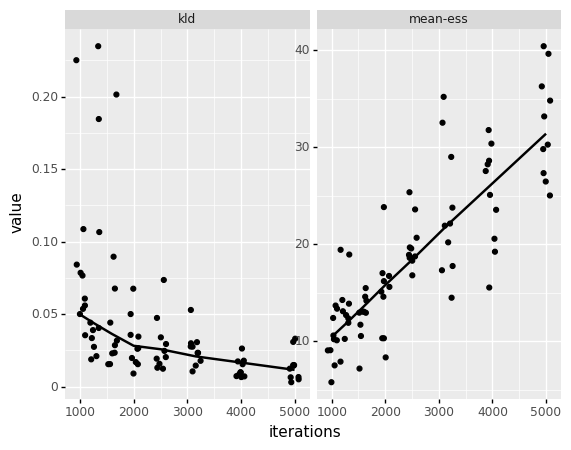

<ggplot: (8753648696724)>

In [7]:
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

Example run of results.

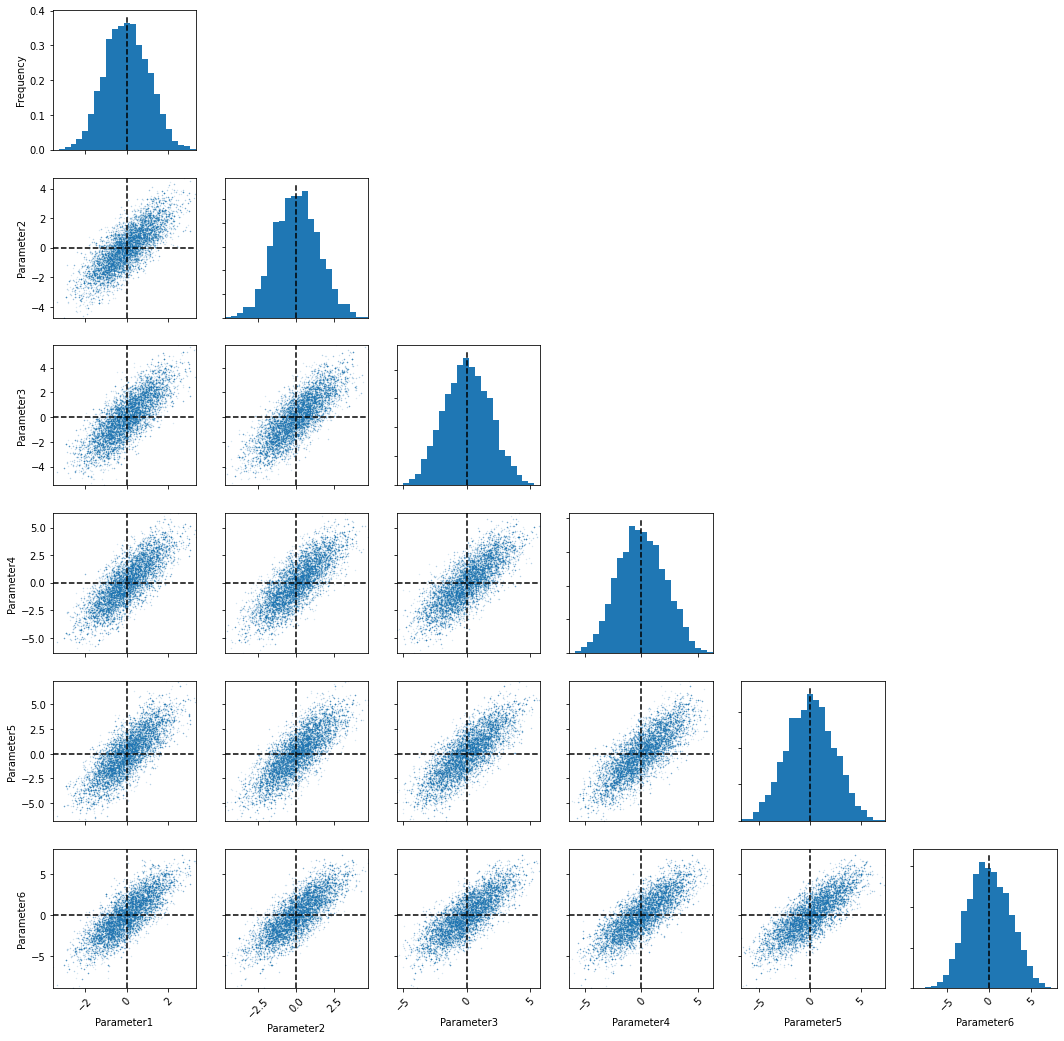

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
param 1  0.01    1.03    -1.95   -0.71  0.00   0.73   2.00     1.04    83.30  15.97
param 2  0.01    1.44    -2.70   -1.02  0.00   0.98   2.84     1.04    81.71  15.66
param 3  0.01    1.80    -3.38   -1.26  -0.00  1.28   3.59     1.04    79.93  15.32
param 4  0.01    2.04    -3.85   -1.42  -0.03  1.46   3.93     1.05    73.67  14.12
param 5  0.05    2.28    -4.44   -1.57  0.07   1.58   4.45     1.05    74.77  14.33
param 6  0.04    2.49    -4.59   -1.73  -0.06  1.82   4.95     1.05    77.69  14.89


In [8]:
n_chains = 4
n_iterations = 4000
n_warmup = 500

log_pdf = pints.toy.HighDimensionalGaussianLogPDF(dimension=6, rho=0.8)
x0 = np.random.uniform(-4, 4, size=(n_chains, 6))
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.MALAMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_epsilon([1.0] * 6)

chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.pairwise(np.vstack(chains), kde=False, ref_parameters=([0] * 6))

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

Again the estimated means compare well with the theoretical. Now comparing the theoretical and empirical cdfs: again, these look fine.

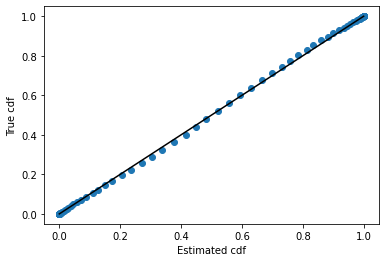

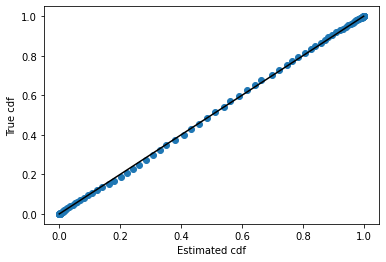

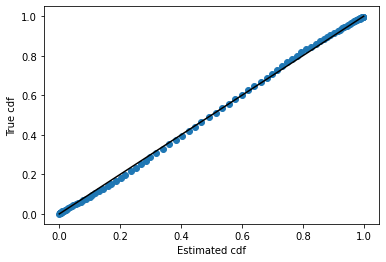

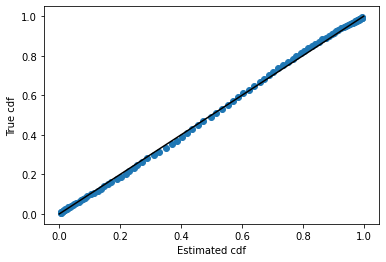

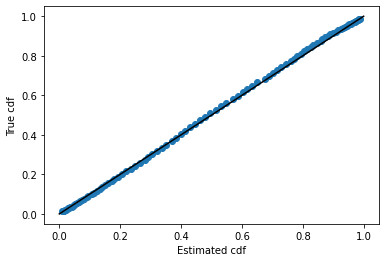

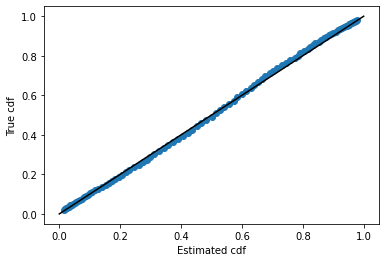

[None, None, None, None, None, None]

In [9]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], np.sqrt(i + 1)) for i in range(6)]

# Banana

In [10]:
test = run_replicates(np.geomspace(1000, 5000, 8), 10, test_mala_mcmc_on_banana)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
df.to_csv("experimental_data/mala_mcmc_banana.csv")

/home/fergus/GitRepos/pints-team/method-merge-tests/venv/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


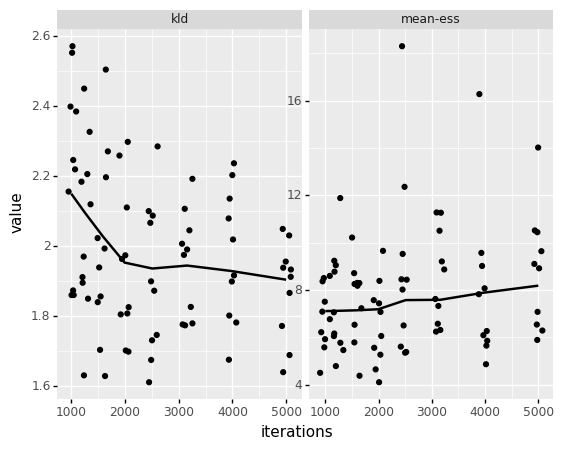

<ggplot: (8753648162148)>

In [11]:
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

The banana is a hard problem with a low ESS. But the KLD is moving in the right direction.

Example run of results.

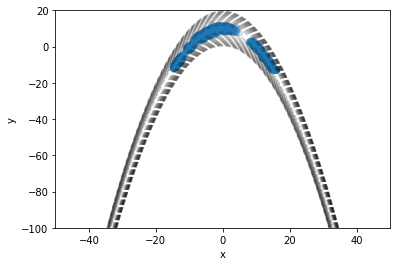

In [12]:
n_chains = 4
n_iterations = 1000
n_warmup = 500

log_pdf = pints.toy.TwistedGaussianLogPDF(dimension=2, b=0.1)
log_prior = pints.MultivariateGaussianLogPrior([0, 0],
                                               [[10, 0], [0, 10]])
x0 = log_prior.sample(n_chains)
sigma0 = np.diag(np.array([1, 3]))

levels = np.linspace(-50, -1, 20)
x = np.linspace(-50, 50, 250)
y = np.linspace(-100, 20, 250)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf([i, j]) for i in x] for j in y]

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.MALAMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_epsilon([0.8] * 2)

chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlim(-50, 50)
plt.ylim(-100, 20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Annulus

In [13]:
test = run_replicates(np.geomspace(1000, 5000, 8), 10,
                      test_mala_mcmc_on_annulus)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
df.to_csv("experimental_data/mala_mcmc_annulus.csv")

/home/fergus/GitRepos/pints-team/method-merge-tests/venv/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


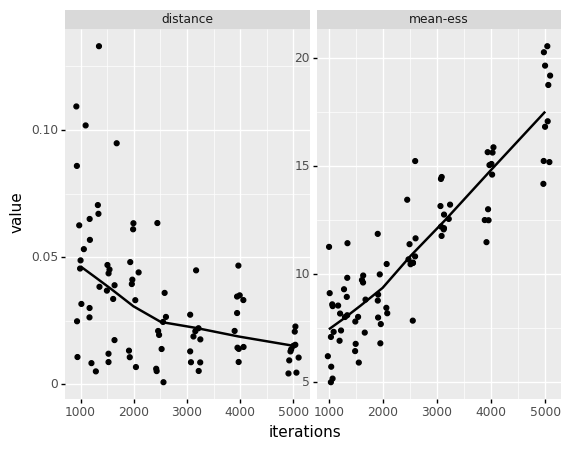

<ggplot: (8753647912527)>

In [14]:
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

The draws trend closer to convergence as the number of iterations increases, although the effective sample size is low here.

Example run.

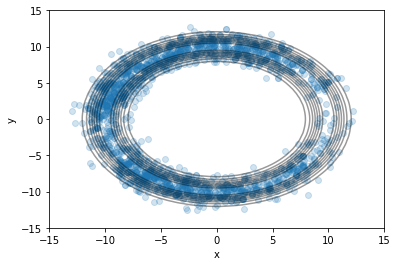

In [15]:
n_chains = 4
n_iterations = 1000
n_warmup = 500

log_pdf = pints.toy.AnnulusLogPDF()
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.MALAMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_epsilon([1.2] * 2)

chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.4)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Multimodal Gaussian

In [16]:
test = run_replicates(np.geomspace(1000, 5000, 8), 10,
                      test_mala_mcmc_on_multimodal_gaussian)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
df.to_csv("experimental_data/mala_mcmc_multimodal_gaussian.csv")



/home/fergus/GitRepos/pints-team/method-merge-tests/venv/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


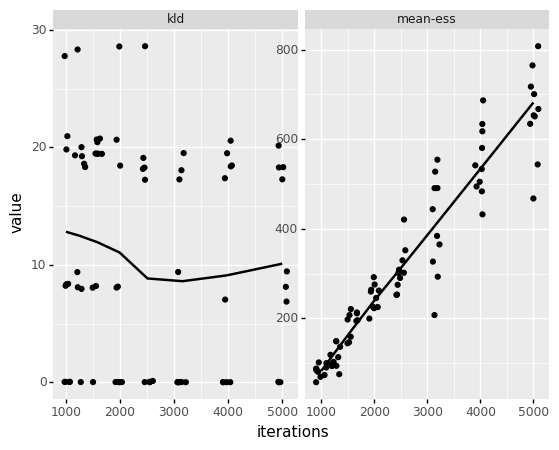

<ggplot: (8753647961480)>

In [17]:
# remove high values of kld to see general trend
# test1 = test.query('kld < 1')
# df1 = pd.melt(test1, id_vars=['iterations', 'replicate'])

(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

With the few outliers removed, the KLD appears to be moving in the correct direction as iterations increase.

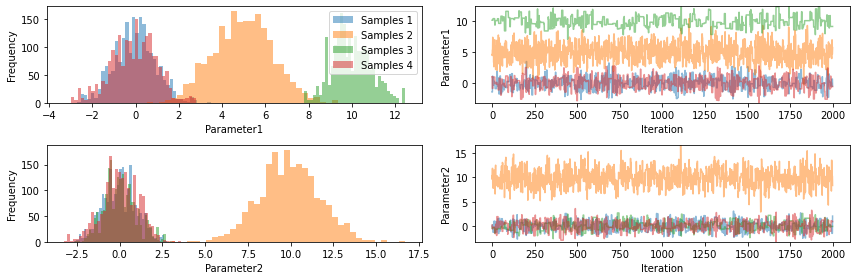

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
param 1  3.71    4.31    -1.75   -0.03  2.35   8.12   11.28    4.16    1249.47  392.52
param 2  2.51    4.46    -1.73   -0.47  0.45   3.24   12.22    3.88    1157.75  363.71


In [18]:
n_chains = 4
n_iterations = 2000
n_warmup = 500

covariances = [[[1, 0], [0, 1]],
               [[2, 0.8], [0.8, 3]],
               [[1, -0.5], [-0.5, 1]]]
log_pdf = pints.toy.MultimodalGaussianLogPDF(modes=[[0, 0], [5, 10], [10, 0]],
                                             covariances=covariances)
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.MALAMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_epsilon([2.0] * 2)

chains = controller.run()

pints.plot.trace(chains)

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

Clearly this multimodal distribution requires many draws to reach convergence.

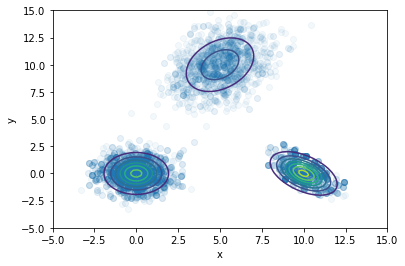

In [19]:
samples = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.scatter(samples[:,0], samples[:,1], alpha=0.05)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Cone

In [20]:
test = run_replicates(np.geomspace(1000, 5000, 8), 10,
                      test_mala_mcmc_on_cone)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
df.to_csv("experimental_data/mala_mcmc_cone.csv")

/home/fergus/GitRepos/pints-team/method-merge-tests/venv/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


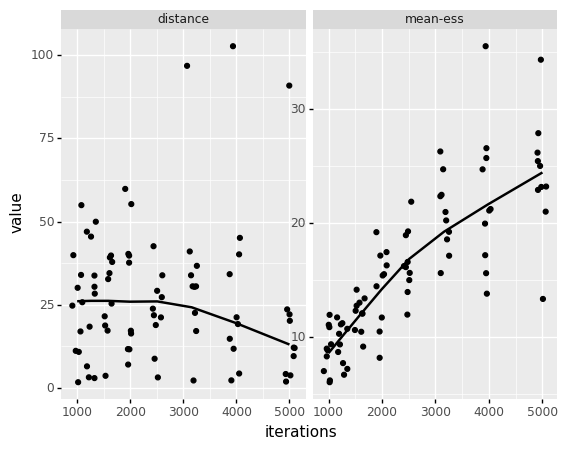

<ggplot: (8753648701428)>

In [21]:
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

Again, the cone problem, with its long tails, is really hard.

Now showing an example run.

Running...
Using Metropolis-Adjusted Langevin Algorithm (MALA)
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0.5       0.5       0.5       0.5        0:00.0
2     12     0.667     0.667     0.667     0.667      0:00.0
3     16     0.75      0.75      0.75      0.5        0:00.0
20    84     0.952381  0.952381  0.952381  0.81       0:00.0
40    164    0.976     0.927     0.976     0.902439   0:00.1
60    244    0.967     0.918     0.984     0.885      0:00.1
80    324    0.962963  0.938     0.988     0.914      0:00.1
100   404    0.960396  0.950495  0.990099  0.931      0:00.1
120   484    0.967     0.959     0.992     0.942      0:00.1
140   564    0.964539  0.964539  0.993     0.95       0:00.2
160   644    0.969     0.957     0.994     0.957      0:00.2
180   724    0.972     0.961326  0.994     0.961326   0:00.2
200   804    0.975     0.965     0

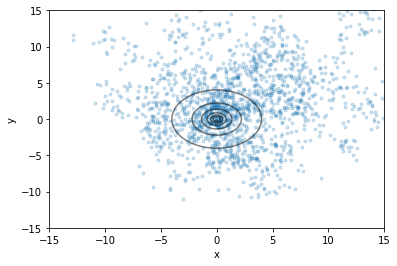

True normed mean = 8.638816024714002
Sample normed mean = 9.428918819542533
True normed var = 65.40423915068341
Sample normed var = 64.62073581991679


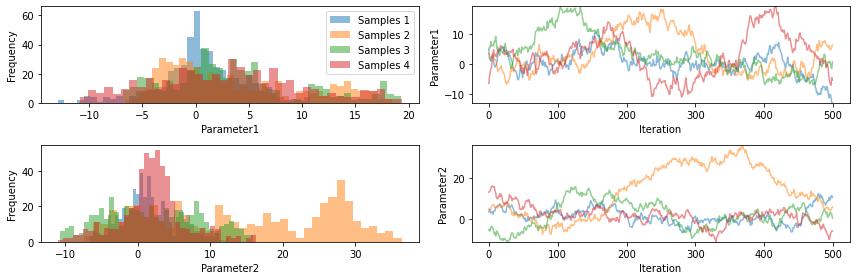

In [22]:
nchains = 4
log_pdf = pints.toy.ConeLogPDF(dimensions=2, beta=0.6)
x0 = log_pdf.sample(nchains)
mcmc = pints.MCMCController(log_pdf, nchains, x0, method=pints.MALAMCMC)

# Set maximum number of iterations
mcmc.set_max_iterations(1000)

# Disable logging
mcmc.set_log_to_screen(True)

for sampler in mcmc.samplers():
    sampler.set_epsilon([1.0] * 2)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Check convergence and other properties of chains
results = pints.MCMCSummary(chains=chains, time=mcmc.time(),
                            parameter_names=['mean dim 1', 'mean dim 2'])
print(results)

# Discard warm-up
chains = [chain[500:] for chain in chains]
stacked = np.vstack(chains)

# overlay draws on contours
num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

d = list(map(lambda x: np.linalg.norm(x), stacked))
a_mean = np.mean(d)
a_var = np.var(d)

print("True normed mean = " + str(log_pdf.mean_normed()))
print("Sample normed mean = " + str(a_mean))

print("True normed var = " + str(log_pdf.var_normed()))
print("Sample normed var = " + str(a_var))

# Show traces and histograms
pints.plot.trace(chains)
plt.show()

# High dimensional Gaussian

In [23]:
test = run_replicates(np.geomspace(1000, 5000, 8), 10,
                      test_mala_mcmc_on_high_dim_gaussian)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
df.to_csv("experimental_data/mala_mcmc_high_dim_gaussian.csv")

/home/fergus/GitRepos/pints-team/method-merge-tests/venv/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


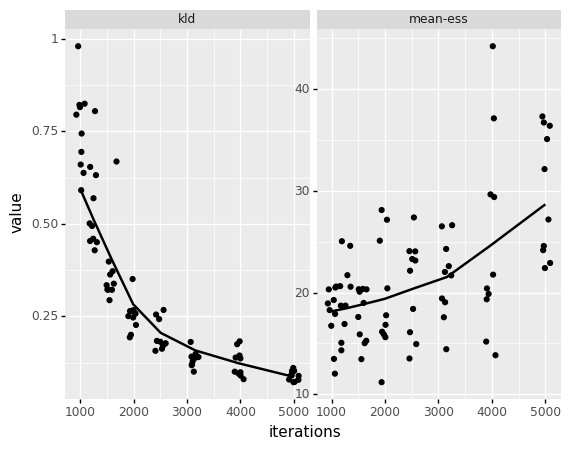

<ggplot: (8753650766514)>

In [24]:
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))